*Random Forest Training and Classification*

In [27]:
%pip install numpy matplotlib scipy pandas seaborn scikit-learn shap 



[notice] A new release of pip available: 22.3.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



Cross-validation scores: [0.74064289 0.7685702  0.77333333 0.78544542 0.76178235]
Average CV score: 0.7659548383917676
CV score std: 0.01482747164500557

Test Set Performance:
              precision    recall  f1-score   support

           0       0.73      0.86      0.79       314
           1       0.85      0.71      0.77       351

    accuracy                           0.78       665
   macro avg       0.79      0.79      0.78       665
weighted avg       0.79      0.78      0.78       665



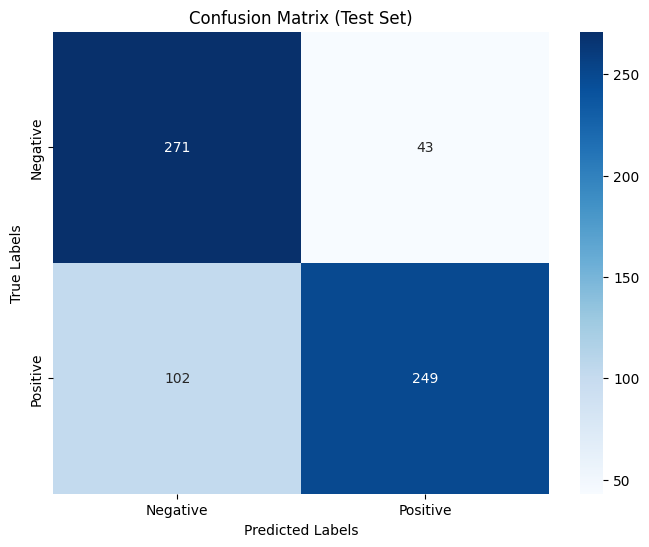

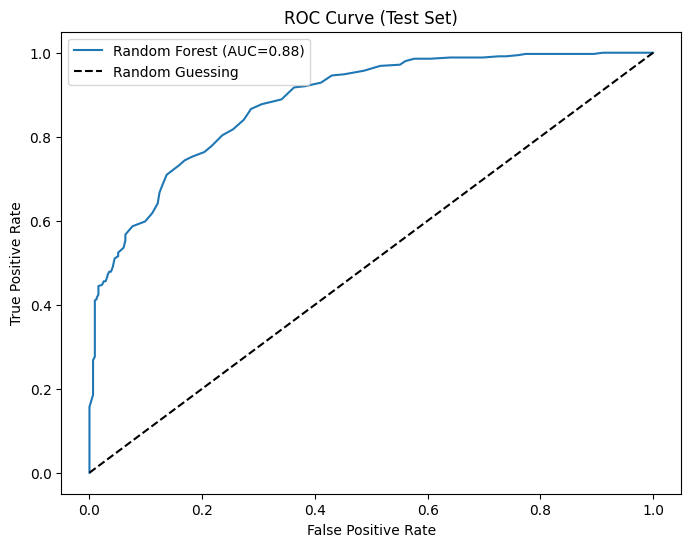

C:\Users\imohm\AppData\Local\Temp\ipykernel_4364\308118820.py:80: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_importances, y=top_features, palette='viridis')


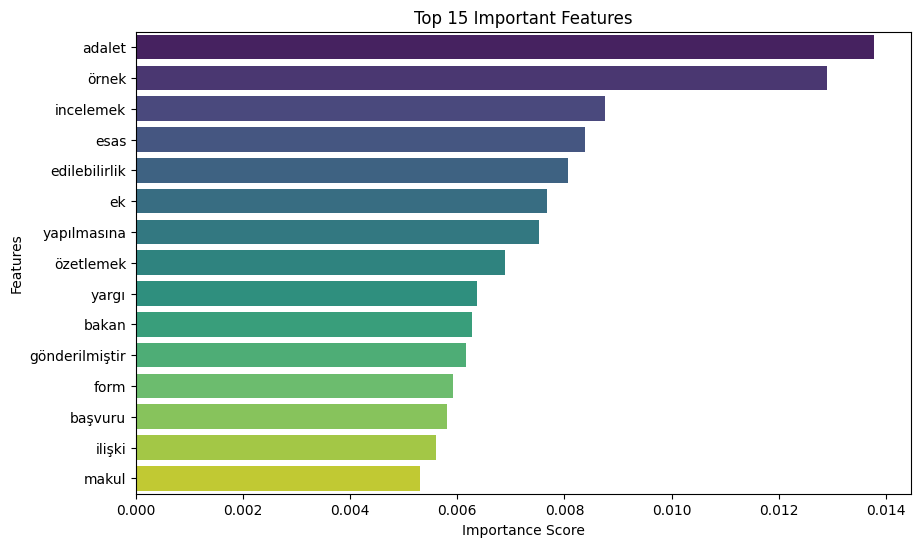

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
import json

def load_data(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        return pd.DataFrame(json.load(file))

# Load data
train_data = load_data('train_processed.json')
dev_data = load_data('dev_processed.json')
test_data = load_data('test_processed.json')

# Combine train and dev data
train_dev_data = pd.concat([train_data, dev_data])
X_train_dev = train_dev_data['text']
y_train_dev = train_dev_data['labels']
X_test = test_data['text']
y_test = test_data['labels']

# Vectorize text data using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X_train_dev_vectorized = vectorizer.fit_transform(X_train_dev).toarray()
X_test_vectorized = vectorizer.transform(X_test).toarray()

# Initialize and train Random Forest
clf = RandomForestClassifier(n_estimators=100, random_state=42)

cv_scores = cross_val_score(clf, X_train_dev_vectorized, y_train_dev, cv=5, scoring='f1')
print("\nCross-validation scores:", cv_scores)
print("Average CV score:", cv_scores.mean())
print("CV score std:", cv_scores.std())

# Train final model on full training data
clf.fit(X_train_dev_vectorized, y_train_dev)

# Evaluate on test set
y_pred = clf.predict(X_test_vectorized)
y_pred_proba = clf.predict_proba(X_test_vectorized)[:, 1]

print("\nTest Set Performance:")
print(classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix (Test Set)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"Random Forest (AUC={roc_auc_score(y_test, y_pred_proba):.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guessing")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Test Set)")
plt.legend()
plt.show()

# Feature Importance Plot
feature_importances = clf.feature_importances_
top_features_idx = feature_importances.argsort()[-15:][::-1]
top_features = [vectorizer.get_feature_names_out()[i] for i in top_features_idx]
top_importances = feature_importances[top_features_idx]

plt.figure(figsize=(10, 6))
sns.barplot(x=top_importances, y=top_features, palette='viridis')
plt.title('Top 15 Important Features')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

*SHAP Values and Plots*

In [32]:

print("Shape of X_test:", X_test.shape)


Shape of X_test: (665,)


In [34]:
import shap
import numpy as np

# ensure the test set is in dense format for SHAP
X_test_dense = np.array(X_test)
X_test_dense = X_test_vectorized
explainer = shap.TreeExplainer(clf, feature_perturbation='interventional')

# generate SHAP values which measure the impact of each feature on the model output. The SHAP values are calculated for each class
shap_values = explainer.shap_values(X_test_dense, check_additivity=False)
feature_names = vectorizer.get_feature_names_out()
print(f"Number of features: {len(feature_names)}, Data columns: {X_test_dense.shape[1]}")
print(f"Shape of shap_values[1]: {shap_values[1].shape}")
print(f"Shape of X_test_dense: {X_test_dense.shape}")


Number of features: 5000, Data columns: 5000
Shape of shap_values[1]: (5000, 2)
Shape of X_test_dense: (665, 5000)


In [35]:
# Take values for class 1 (index 1)
selected_shap_values = shap_values[:, :, 1]  # (n_samples, n_features)
print(f"Selected SHAP values shape: {selected_shap_values.shape}")
print(f"X_test_dense shape: {X_test_dense.shape}")

Selected SHAP values shape: (665, 5000)
X_test_dense shape: (665, 5000)


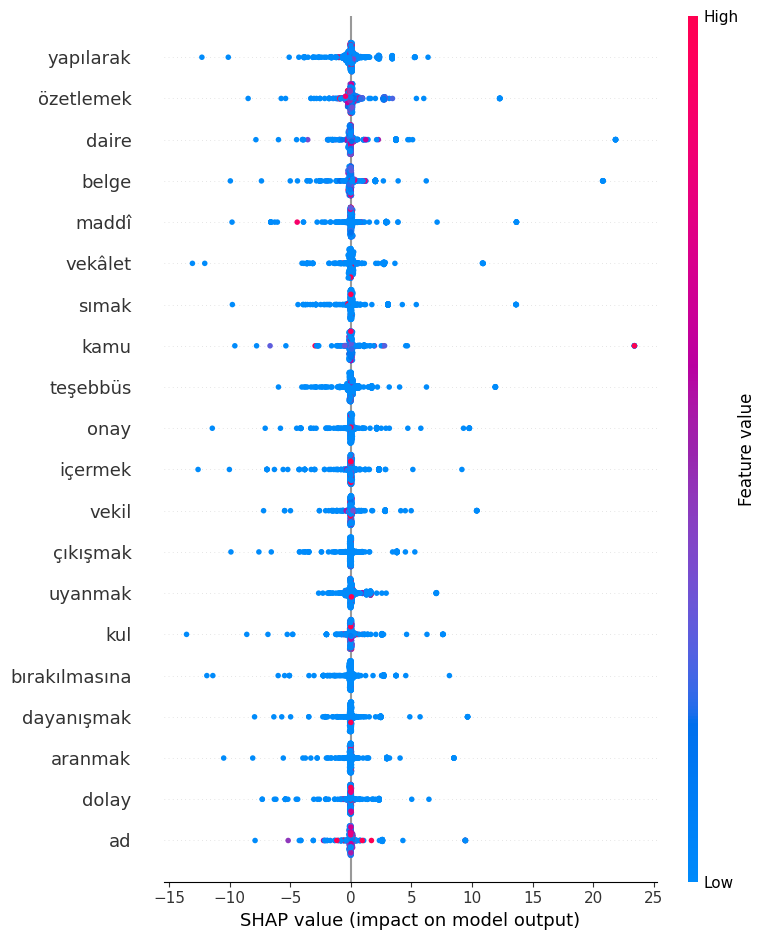

In [36]:
shap.summary_plot(
    selected_shap_values,
    X_test_dense,
    feature_names=feature_names
)